In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [2]:
#データの読み込み
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


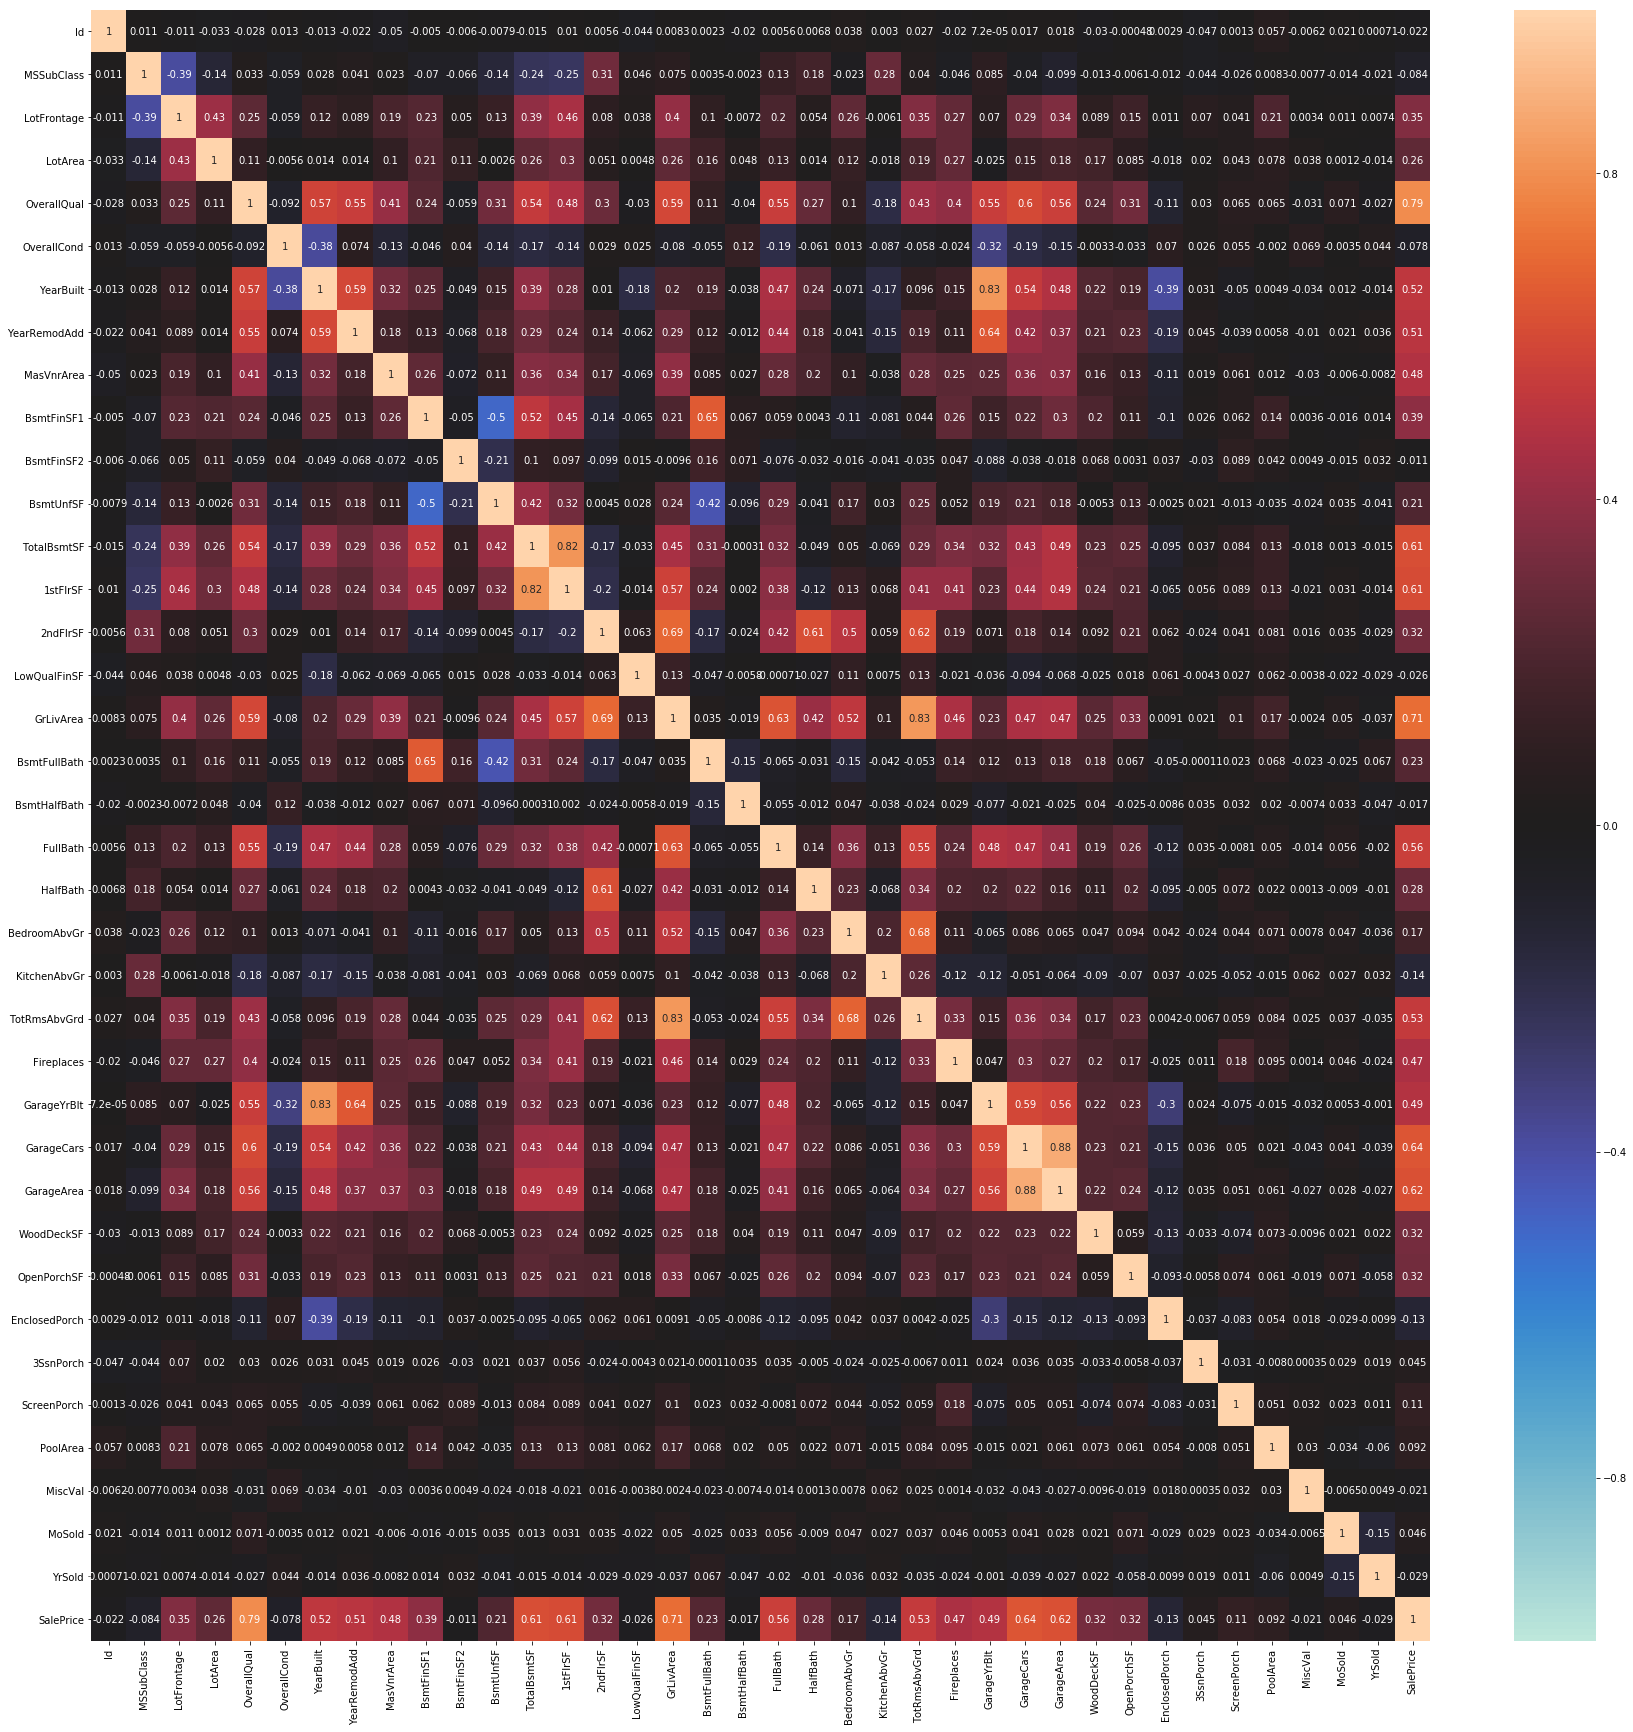

In [5]:
#相関係数行列の可視化
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

In [6]:
df_train.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd', 'GarageYrBlt'], axis=1, inplace=True)

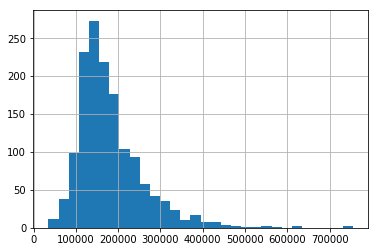

In [7]:
df_train["SalePrice"].hist(bins=30)

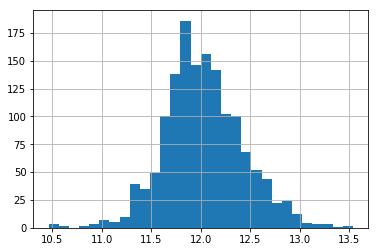

In [8]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
#対数変換後の分布を確認
df_train["SalePrice"].hist(bins=30)

In [9]:
#カテゴリカルでない特徴量
non_categoricals = df_train.dtypes[df_train.dtypes != "object"].index
skewed_feats = df_train[non_categoricals].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.7].index
#歪度0.7より大きい特徴量を対数変換
df_train[skewed_feats] = np.log1p(df_train[skewed_feats])

C:\Users\yutaw\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


In [11]:
#One Hot Encoding
df_train = pd.get_dummies(df_train)
df_tarin = df_train.fillna(df_train.mean())

In [22]:
df_train[skewed_feats]

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.000000,5.017280,6.753438,6.751101,0.000000,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.000000,0.000000,0.0,0.000000
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.000000,5.652489,7.141245,0.000000,0.000000,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.000000,6.075346,6.825460,6.765039,0.000000,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.000000,0.000000,0.0,0.000000
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.000000,6.293419,6.629363,6.629363,0.000000,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.000000,0.000000,0.0,0.000000
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.000000,6.196444,7.044033,6.960348,0.000000,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.000000,0.000000,0.0,0.000000
5,3.931826,4.454347,9.555064,0.000000,6.597146,0.000000,4.174387,6.680855,6.340359,0.000000,7.217443,0.000000,0.693147,3.713572,3.433987,0.000000,5.771441,0.000000,0.0,6.552508
6,3.044522,4.330733,9.218804,5.231109,7.222566,0.000000,5.762051,7.430707,0.000000,0.000000,7.435438,0.000000,0.693147,5.545177,4.060443,0.000000,0.000000,0.000000,0.0,0.000000
7,4.110874,4.207109,9.247925,5.484797,6.756932,3.496508,5.379897,7.010312,6.891626,0.000000,7.645398,0.000000,0.693147,5.463832,5.323010,5.433722,0.000000,0.000000,0.0,5.860786
8,3.931826,3.951244,8.719481,0.000000,0.000000,0.000000,6.859615,6.859615,6.624065,0.000000,7.481556,0.000000,1.098612,4.510860,0.000000,5.327876,0.000000,0.000000,0.0,0.000000
9,5.252273,3.931826,8.912069,0.000000,6.747587,0.000000,4.948760,6.899723,0.000000,0.000000,6.982863,0.000000,1.098612,0.000000,1.609438,0.000000,0.000000,0.000000,0.0,0.000000


In [12]:
df_train = df_train.fillna(df_train.mean())

In [13]:
#学習データ、テストデータに分割
X = df_train.loc[:,df_train.columns[df_train.columns != "SalePrice"]]
y = df_train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
X.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,...,0,0,0,1,0,0,0,0,1,0
1,2,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,...,0,0,0,1,0,0,0,0,1,0
2,3,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,...,0,0,0,1,0,0,0,0,1,0
3,4,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,...,0,0,0,1,1,0,0,0,0,0
4,5,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,...,0,0,0,1,0,0,0,0,1,0


In [15]:
reg = Lasso(alpha=0.0004)
reg.fit(X_train, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [16]:
Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
normalize=False, positive=False, precompute=False, random_state=None,
selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [17]:
y_pred = reg.predict(X_test)

In [18]:
print("ラッソ回帰でのRMSE:",np.sqrt(mean_squared_error(y_pred, y_test)))

ラッソ回帰でのRMSE: 0.1376794641392094


In [19]:
lgb_train = lgb.Dataset(X_train,y_train)

In [20]:
params = {'task': 'train','boosting_type': 'gbdt','objective': 'regression','metric': {'l2'},'num_leaves': 256,
'learning_rate': 0.01,'num_iterations':2000,'feature_fraction': 0.4,'bagging_fraction': 0.7,'bagging_freq': 5}
gbm = lgb.train(params, lgb_train, num_boost_round=1500)
y_test_pred_lgb = gbm.predict(np.array(X_test), num_iteration=gbm.best_iteration)
#RMSE
print("LightGBMでのRMSE:",np.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))

C:\Users\yutaw\Anaconda3\envs\tensorflow\lib\site-packages\lightgbm\engine.py:111: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LightGBMでのRMSE: 0.12014969595732712


In [21]:
print("LightGBM+Lassoのスタッキング時のRMSE:",np.sqrt(mean_squared_error(y_test, (y_pred*0.6+y_test_pred_lgb*0.4))))

LightGBM+Lassoのスタッキング時のRMSE: 0.12404871772136235


In [ ]:
#全データで学習
reg.fit(X, y)
lgb_train_full = lgb.Dataset(X,y)
gbm = lgb.train(params, lgb_train_full, num_boost_round=1500)

In [ ]:
#ラッソ・LightGBMの予測及びスタッキング
pred = np.expm1(reg.predict(X_for_test))
pred2 = np.expm1(gbm.predict(X_for_test))
pred3 = (pred*0.6+pred2*0.4)

In [ ]:
# solution = pd.DataFrame({"id":df_test.Id, "SalePrice":pred3})
# solution.to_csv("test_lasso2.csv", index = False)